# **5. Uso de tecnicas de optimizacion computacional a los modelos Benchmark**

## **5.0 Previo a probar tecnicas de optimizacion**

In [119]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import math
import time
import faiss
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN



from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc, roc_auc_score, classification_report
)

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


## **5.1 Técnicas de optimización para KNN**

In [120]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [121]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [123]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [124]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [125]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    """Evalúa un modelo y grafica sus métricas principales"""
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n🔹 {nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

### **5.1.1 KNN estándar**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


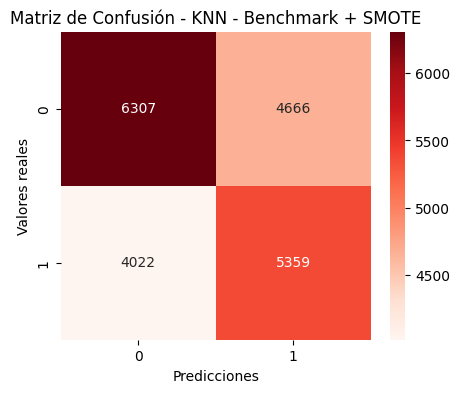


🔹 KNN - Benchmark + SMOTE
Accuracy: 0.573 | Precision: 0.535 | Recall: 0.571 | F1: 0.552
AUC: 0.602
              precision    recall  f1-score   support

           0       0.61      0.57      0.59     10973
           1       0.53      0.57      0.55      9381

    accuracy                           0.57     20354
   macro avg       0.57      0.57      0.57     20354
weighted avg       0.58      0.57      0.57     20354



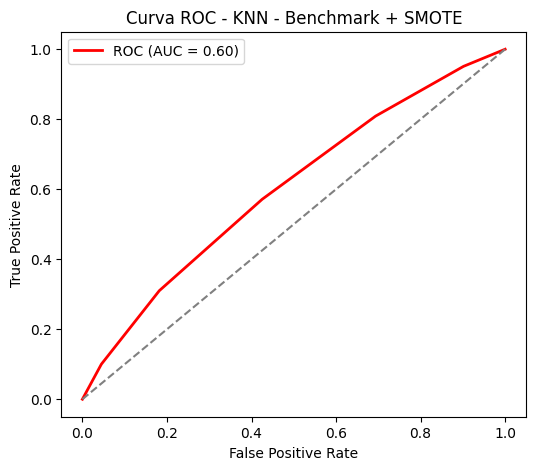

In [126]:

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time



resultados_knn = []


start = time.time()
knn_std = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])

knn_std.fit(X_train, y_train)
y_pred_std = knn_std.predict(X_test)
end = time.time()
metrics_knnstd_smote = {
    "Modelo": "KNN - Benchmark + SMOTE",
    "Accuracy": accuracy_score(y_test, y_pred_std),
    "Precision": precision_score(y_test, y_pred_std),
    "Recall": recall_score(y_test, y_pred_std),
    "F1": f1_score(y_test, y_pred_std),
    "AUC": roc_auc_score(y_test, y_pred_std),
    "Tiempo (s)": round(end - start, 3)
}

evaluar_modelo(knn_std, X_test, y_test, "KNN - Benchmark + SMOTE")
resultados_knn.append(metrics_knnstd_smote)

### **5.1.2 Mejor modelo KNN actual usando KD-Trees**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


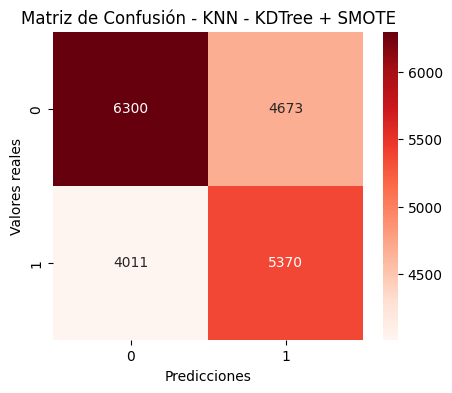


🔹 KNN - KDTree + SMOTE
Accuracy: 0.573 | Precision: 0.535 | Recall: 0.572 | F1: 0.553
AUC: 0.602
              precision    recall  f1-score   support

           0       0.61      0.57      0.59     10973
           1       0.53      0.57      0.55      9381

    accuracy                           0.57     20354
   macro avg       0.57      0.57      0.57     20354
weighted avg       0.58      0.57      0.57     20354



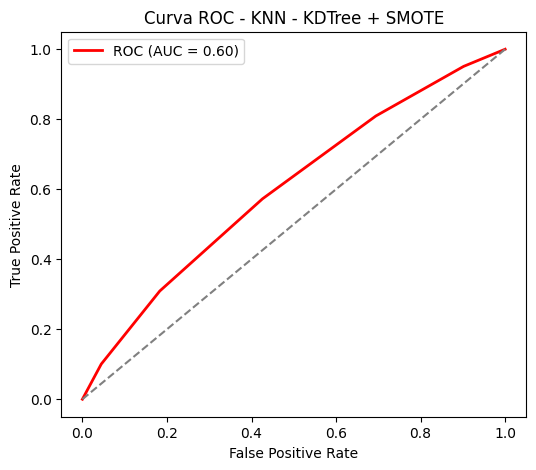

In [127]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

start = time.time()
knn_kd_smote = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree", n_jobs=-1))
])

knn_kd_smote.fit(X_train, y_train)
y_pred_kd_smote = knn_kd_smote.predict(X_test)
end = time.time()

metrics_kd_smote = {
    "Modelo": "KNN - KDTree + SMOTE",
    "Accuracy": accuracy_score(y_test, y_pred_kd_smote),
    "Precision": precision_score(y_test, y_pred_kd_smote),
    "Recall": recall_score(y_test, y_pred_kd_smote),
    "F1": f1_score(y_test, y_pred_kd_smote),
    "AUC": roc_auc_score(y_test, y_pred_kd_smote),
    "Tiempo (s)": round(end - start, 3)
}

evaluar_modelo(knn_kd_smote, X_test, y_test, "KNN - KDTree + SMOTE")
resultados_knn.append(metrics_kd_smote)

### **5.1.3 Mejor modelo KNN actual usando usando Ball Trees**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


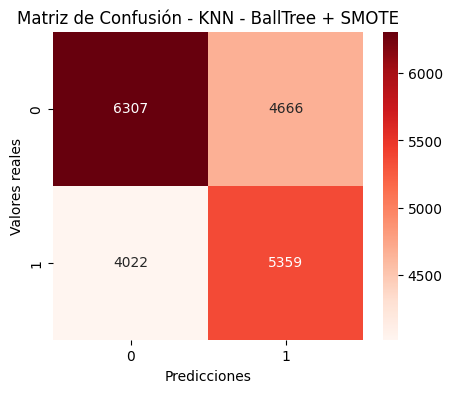


🔹 KNN - BallTree + SMOTE
Accuracy: 0.573 | Precision: 0.535 | Recall: 0.571 | F1: 0.552
AUC: 0.602
              precision    recall  f1-score   support

           0       0.61      0.57      0.59     10973
           1       0.53      0.57      0.55      9381

    accuracy                           0.57     20354
   macro avg       0.57      0.57      0.57     20354
weighted avg       0.58      0.57      0.57     20354



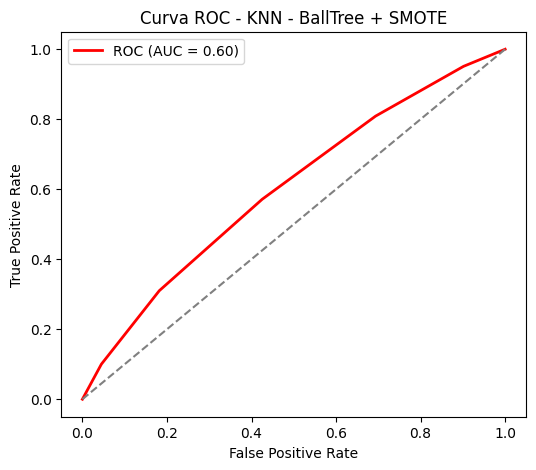

In [128]:
start = time.time()
knn_ball = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", KNeighborsClassifier(n_neighbors=5, algorithm="ball_tree", n_jobs=-1))
])
knn_ball.fit(X_train, y_train)
y_pred_ball = knn_ball.predict(X_test)
end = time.time()
metrics_ball_smote = {
    "Modelo": "KNN - BallTree + SMOTE",
    "Accuracy": accuracy_score(y_test, y_pred_ball),
    "Precision": precision_score(y_test, y_pred_ball),
    "Recall": recall_score(y_test, y_pred_ball),
    "F1": f1_score(y_test, y_pred_ball),
    "AUC": roc_auc_score(y_test, y_pred_ball),
    "Tiempo (s)": round(end - start, 3)
}

evaluar_modelo(knn_ball, X_test, y_test, "KNN - BallTree + SMOTE")
resultados_knn.append(metrics_ball_smote)

### **5.1.4 Mejor modelo KNN actual usando usando FAISS**

In [129]:
import faiss
import numpy as np
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


class FAISSKNN:
    def __init__(self, X_train, y_train, k=5):
        self.X_train = np.array(X_train, dtype=np.float32)
        self.y_train = np.array(y_train)
        self.k = k
        self.index = faiss.IndexFlatL2(self.X_train.shape[1])
        self.index.add(self.X_train)

    def predict(self, X_test):
        X_test = np.array(X_test, dtype=np.float32)
        distances, indices = self.index.search(X_test, self.k)
        y_pred = []
        for idxs in indices:
            vecinos = self.y_train[idxs]
            voto = int(vecinos.mean() >= 0.5)
            y_pred.append(voto)
        return np.array(y_pred)

    def predict_proba(self, X_test):
        X_test = np.array(X_test, dtype=np.float32)
        distances, indices = self.index.search(X_test, self.k)
        probs = []
        for idxs in indices:
            vecinos = self.y_train[idxs]
            probs.append(vecinos.mean())  # probabilidad de clase positiva
        return np.column_stack((1 - np.array(probs), np.array(probs)))


c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


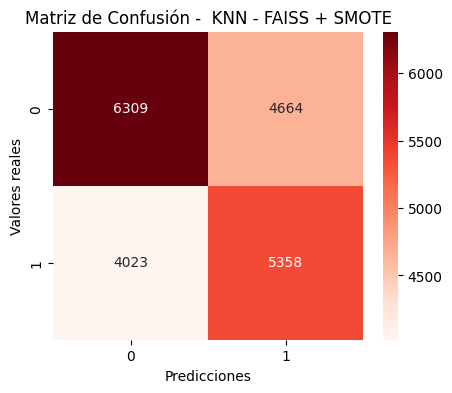


🔹  KNN - FAISS + SMOTE
Accuracy: 0.573 | Precision: 0.535 | Recall: 0.571 | F1: 0.552
AUC: 0.602
              precision    recall  f1-score   support

           0       0.61      0.57      0.59     10973
           1       0.53      0.57      0.55      9381

    accuracy                           0.57     20354
   macro avg       0.57      0.57      0.57     20354
weighted avg       0.58      0.57      0.57     20354



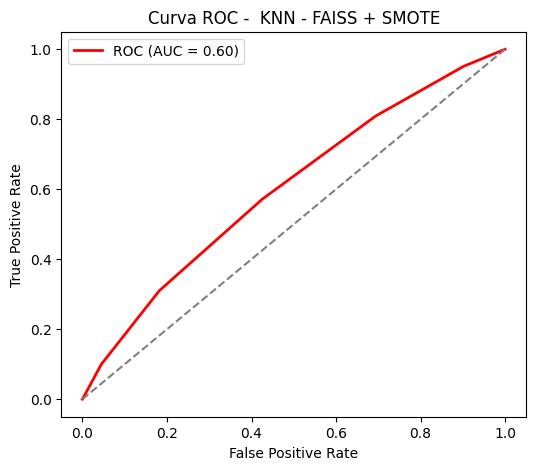

In [130]:
start = time.time()

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_proc, y_train)

faiss_knn = FAISSKNN(X_train_sm, y_train_sm, k=5)

metrics_faiss = evaluar_modelo(faiss_knn, X_test_proc, y_test, " KNN - FAISS + SMOTE")

end = time.time()
metrics_faiss["Tiempo (s)"] = round(end - start, 3)

resultados_knn.append(metrics_faiss)

### **5.1.5 Resultados para KNN y sus metodos de optimizacion**

In [131]:
tabla_resultados = pd.DataFrame(resultados_knn).sort_values("Recall", ascending=False).reset_index(drop=True)
display(tabla_resultados.sort_values(by="Recall", ascending=False))


,Modelo,Accuracy,Precision,Recall,F1,AUC,Tiempo (s)
0,KNN - KDTree + SMOTE,0.573352,0.534701,0.572434,0.552924,0.573285,38.930
1,KNN - Benchmark + SMOTE,0.573155,0.534564,0.571261,0.552303,0.573018,3.383
2,KNN - BallTree + SMOTE,0.573155,0.534564,0.571261,0.552303,0.573018,20.514
3,KNN - FAISS + SMOTE,0.573204,0.534624,0.571154,0.552286,0.601858,28.640


C:\Users\taran\AppData\Local\Temp\ipykernel_21620\1166903581.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Recall", data=tabla_resultados, palette="Reds")


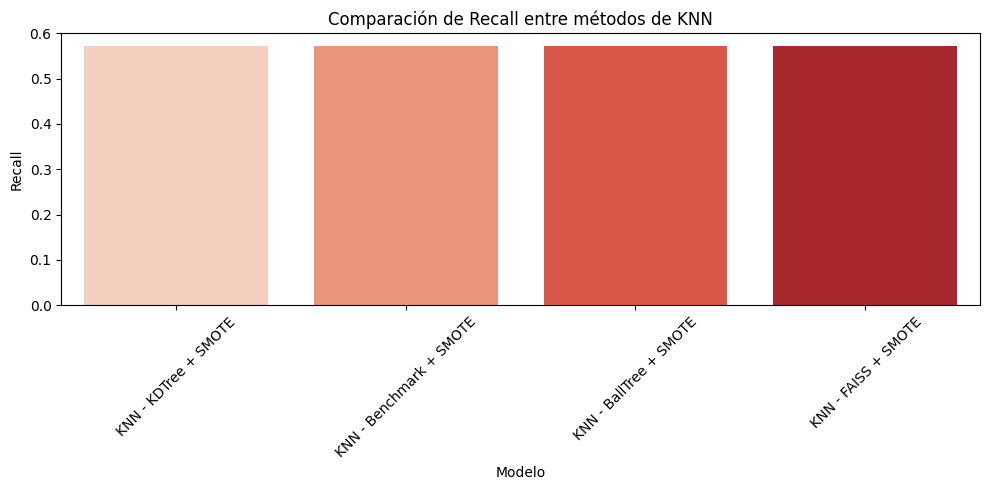

In [132]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="Recall", data=tabla_resultados, palette="Reds")
plt.title("Comparación de Recall entre métodos de KNN")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\taran\AppData\Local\Temp\ipykernel_21620\4080304565.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Tiempo (s)", data=tabla_resultados, palette="Reds")


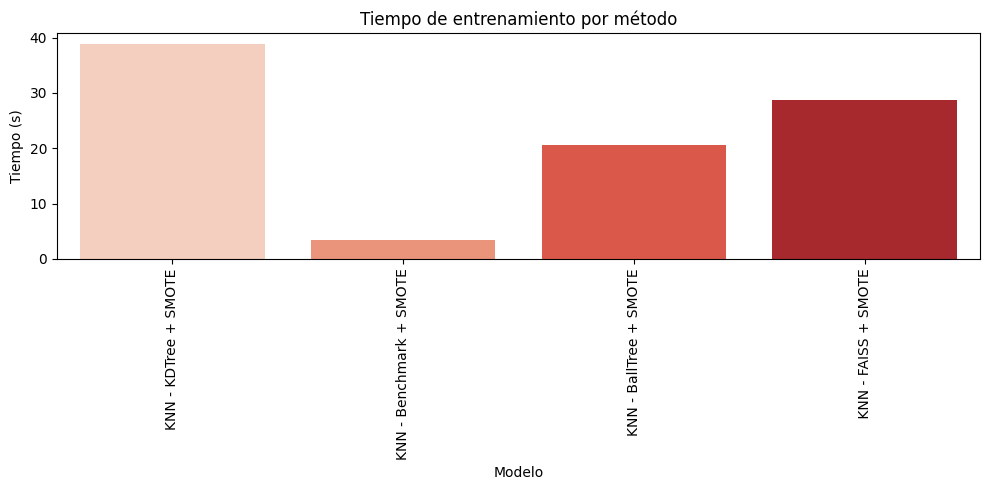

In [133]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="Tiempo (s)", data=tabla_resultados, palette="Reds")
plt.title("Tiempo de entrenamiento por método")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## **5.2 Técnicas de optimización para Clasificador Bayesiano**

Se selccionan las variables explicativas y la respuesta.

In [134]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [135]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [137]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [138]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [139]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n{nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


### **5.2.1 Clasificador Bayesiano estándar**

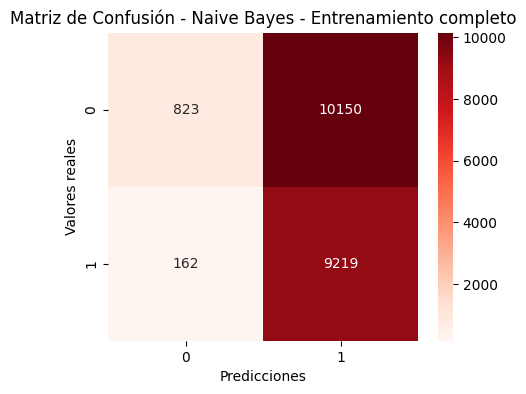


Naive Bayes - Entrenamiento completo
Accuracy: 0.493 | Precision: 0.476 | Recall: 0.983 | F1: 0.641
AUC: 0.642
              precision    recall  f1-score   support

           0       0.84      0.08      0.14     10973
           1       0.48      0.98      0.64      9381

    accuracy                           0.49     20354
   macro avg       0.66      0.53      0.39     20354
weighted avg       0.67      0.49      0.37     20354



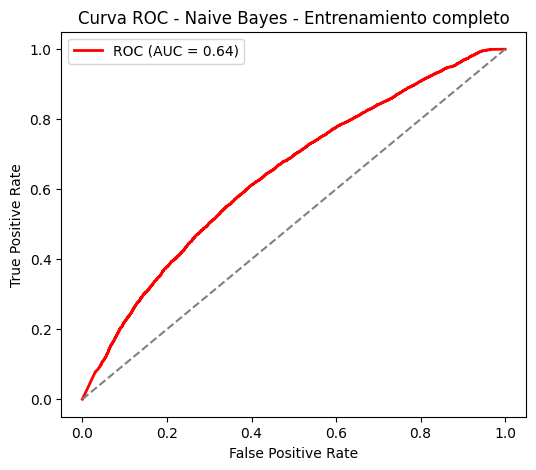

In [140]:
t0 = time.time()
bayes_normal = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GaussianNB())
])

bayes_normal.fit(X_train, y_train)
t1 = time.time()

result_bayes_normal = evaluar_modelo(bayes_normal, X_test, y_test, "Naive Bayes - Entrenamiento completo")
result_bayes_normal["Tiempo (s)"] = round(t1 - t0, 3)

### **5.2.2 Mejor modelo de Clasificador Bayesiano actual usando partial_fit()**

In [141]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

nb_incremental = GaussianNB()
clases = np.unique(y_train)
batch_size = 2000
t0 = time.time()

for i in range(0, len(X_train_proc), batch_size):
    X_batch = X_train_proc[i:i + batch_size]
    y_batch = y_train.iloc[i:i + batch_size]
    nb_incremental.partial_fit(X_batch, y_batch, classes=clases)

t1 = time.time()

In [142]:
y_pred = nb_incremental.predict(X_test_proc)
y_pred_proba = nb_incremental.predict_proba(X_test_proc)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

In [143]:
print("\n Naive Bayes Incremental (Partial Fit)")
print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")

result_bayes_incremental = {
    "Modelo": "Naive Bayes Incremental",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "AUC": auc,
    "Tiempo (s)": round(t1 - t0, 3)
}


 Naive Bayes Incremental (Partial Fit)
Accuracy: 0.494 | Precision: 0.476 | Recall: 0.983 | F1: 0.641 | AUC: 0.642


### **5.2.3 Resultados para Clasificador Bayesiano y sus metodos de optimizacion**

In [144]:
tabla_resultados = pd.DataFrame([
    result_bayes_normal,
    result_bayes_incremental
])
print("\n Comparación de modelos:")
display(tabla_resultados.sort_values(by="Recall", ascending=False))



 Comparación de modelos:


,Modelo,Accuracy,Precision,Recall,F1,AUC,Tiempo (s)
0,Naive Bayes - Entrenamiento completo,0.493367,0.475967,0.982731,0.641322,0.642233,1.715
1,Naive Bayes Incremental,0.493515,0.476040,0.982731,0.641389,0.642218,0.677


C:\Users\taran\AppData\Local\Temp\ipykernel_21620\690016218.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Recall", data=tabla_resultados, palette="Reds")


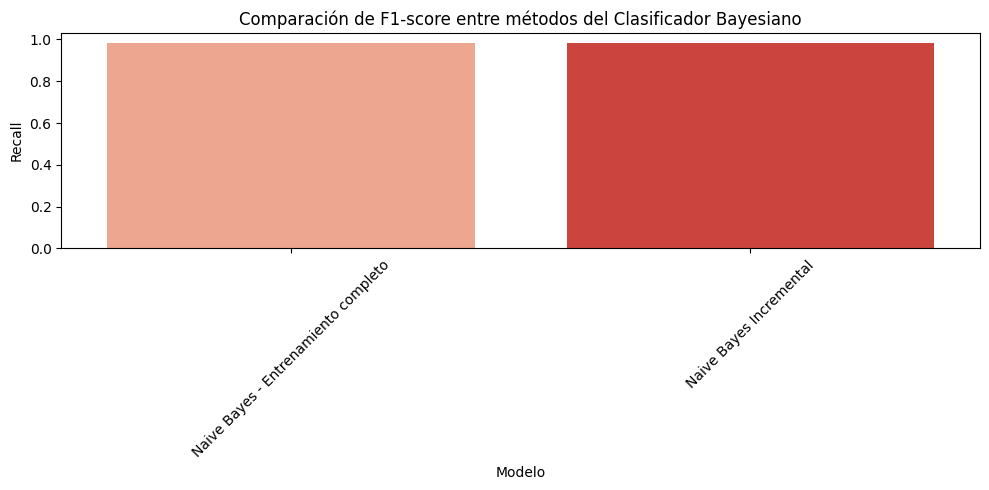

In [145]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="Recall", data=tabla_resultados, palette="Reds")
plt.title("Comparación de F1-score entre métodos del Clasificador Bayesiano")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\taran\AppData\Local\Temp\ipykernel_21620\631096664.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Tiempo (s)", data=tabla_resultados, palette="Reds")


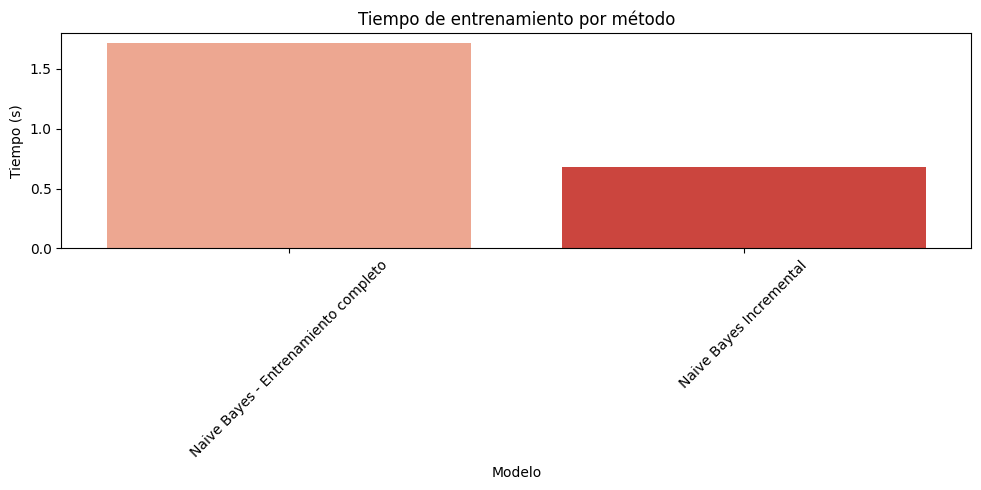

In [146]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="Tiempo (s)", data=tabla_resultados, palette="Reds")
plt.title("Tiempo de entrenamiento por método")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **5.3 Técnicas de optimización para Regresión Logistica (L1/L2)**

In [147]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [148]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [150]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [151]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [152]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n{nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


### **5.3.1 Mejor Regresion Logistica (L1/L2) estándar**

####  **5.3.1.1  Mejor Regresion Logistica (L1) estándar**

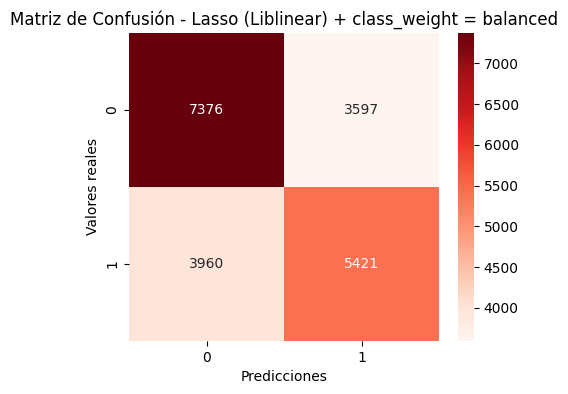


Lasso (Liblinear) + class_weight = balanced
Accuracy: 0.629 | Precision: 0.601 | Recall: 0.578 | F1: 0.589
AUC: 0.681
              precision    recall  f1-score   support

           0       0.65      0.67      0.66     10973
           1       0.60      0.58      0.59      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.63      0.63     20354
weighted avg       0.63      0.63      0.63     20354



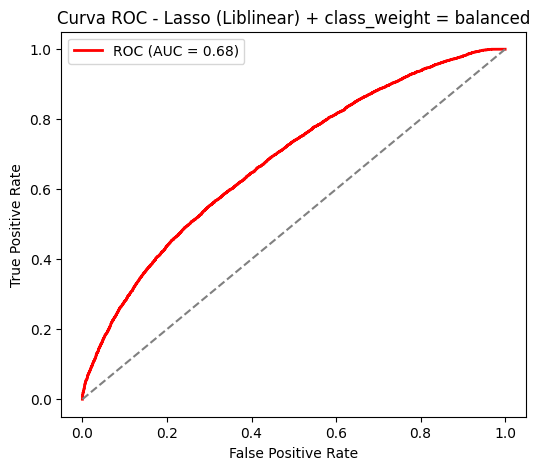

In [153]:
# 🔹 Lasso estándar (solver 'liblinear')
start = time.time()

lasso_std = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l1', 
        solver='liblinear',
        class_weight="balanced", 
        random_state=42))
])

lasso_std.fit(X_train, y_train)
end = time.time()
metrics_lasso_std = evaluar_modelo(lasso_std, X_test, y_test, "Lasso (Liblinear) + class_weight = balanced")
metrics_lasso_std["Tiempo (s)"] = round(end - start, 3)

####  **5.3.1.2 Mejor Regresion Logistica (L2) estándar**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:319: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


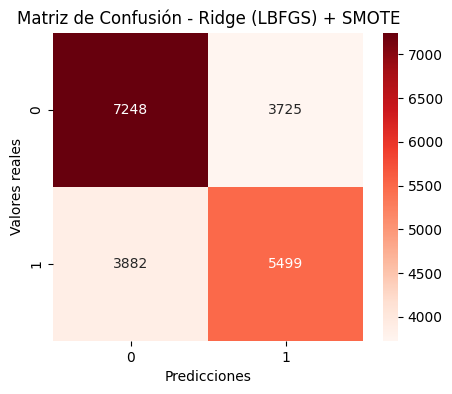


Ridge (LBFGS) + SMOTE
Accuracy: 0.626 | Precision: 0.596 | Recall: 0.586 | F1: 0.591
AUC: 0.680
              precision    recall  f1-score   support

           0       0.65      0.66      0.66     10973
           1       0.60      0.59      0.59      9381

    accuracy                           0.63     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.63      0.63      0.63     20354



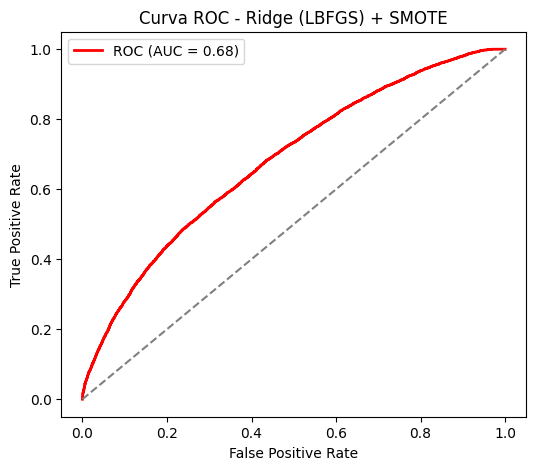

In [154]:
start = time.time()
ridge_std = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ))
])
ridge_std.fit(X_train, y_train)
end = time.time()
metrics_ridge_std = evaluar_modelo(ridge_std, X_test, y_test, "Ridge (LBFGS) + SMOTE")
metrics_ridge_std["Tiempo (s)"] = round(end - start, 3)


### **5.3.2 Regresion Logistica (L1/L2) usando solver=saga**

#### **5.3.2.1 Regresion Logistica (L1) usando solver=saga**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


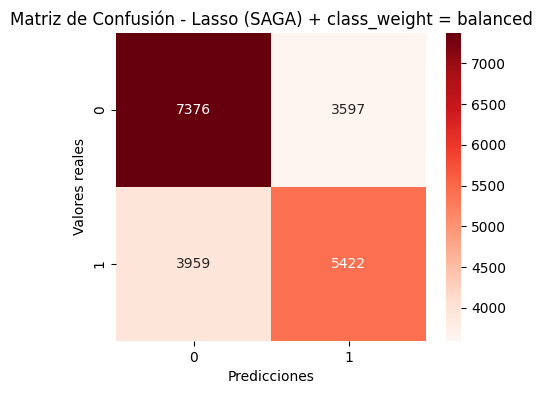


Lasso (SAGA) + class_weight = balanced
Accuracy: 0.629 | Precision: 0.601 | Recall: 0.578 | F1: 0.589
AUC: 0.681
              precision    recall  f1-score   support

           0       0.65      0.67      0.66     10973
           1       0.60      0.58      0.59      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.63      0.63     20354
weighted avg       0.63      0.63      0.63     20354



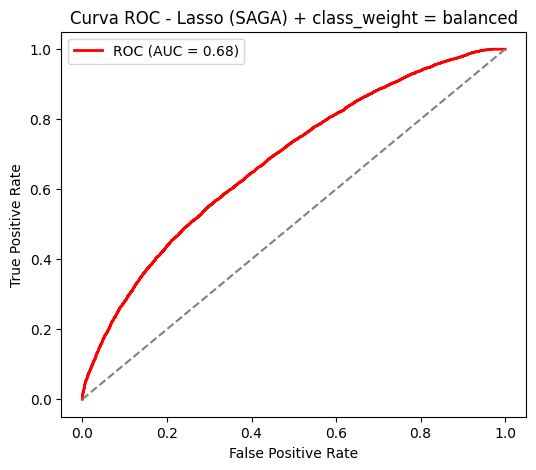

In [155]:
start = time.time()

lasso_saga = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l1', 
        solver='saga',
        max_iter=1000,
        class_weight="balanced", 
        random_state=42,
        n_jobs=-1))
])

lasso_saga.fit(X_train, y_train)
end = time.time()
metrics_lasso_saga = evaluar_modelo(lasso_saga, X_test, y_test, "Lasso (SAGA) + class_weight = balanced")
metrics_lasso_saga["Tiempo (s)"] = round(end - start, 3)


#### **5.3.2.2 Regresion Logistica (L2) usando solver=saga**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


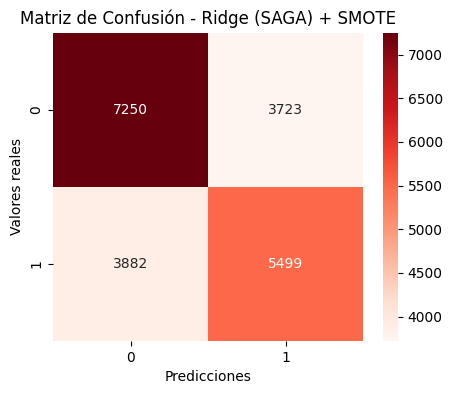


Ridge (SAGA) + SMOTE
Accuracy: 0.626 | Precision: 0.596 | Recall: 0.586 | F1: 0.591
AUC: 0.680
              precision    recall  f1-score   support

           0       0.65      0.66      0.66     10973
           1       0.60      0.59      0.59      9381

    accuracy                           0.63     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.63      0.63      0.63     20354



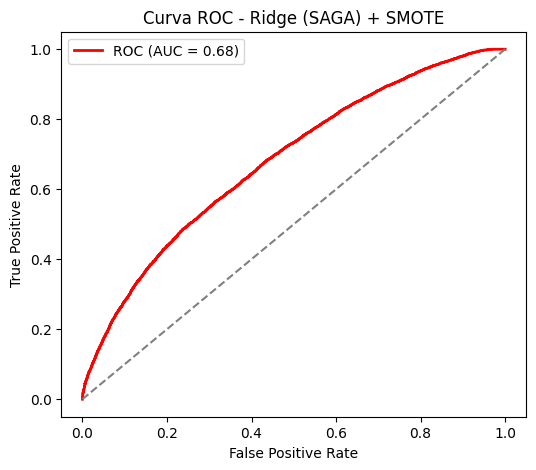

In [156]:
start = time.time()

ridge_saga = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="saga",
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ))
])

ridge_saga.fit(X_train, y_train)
end = time.time()
metrics_ridge_saga = evaluar_modelo(ridge_saga, X_test, y_test, "Ridge (SAGA) + SMOTE")
metrics_ridge_saga["Tiempo (s)"] = round(end - start, 3)

### **5.3.3 Resultados para Regresion Logistica y sus metodos de optimizacion**

In [157]:
resultados = pd.DataFrame([
    metrics_ridge_std, metrics_ridge_saga,
    metrics_lasso_std, metrics_lasso_saga
])

print("\n Resultados comparativos (Ridge/Lasso con SAGA):")
display(resultados.sort_values("F1", ascending=False).reset_index(drop=True))


 Resultados comparativos (Ridge/Lasso con SAGA):


,Modelo,Accuracy,Precision,Recall,F1,AUC,Tiempo (s)
0,Ridge (SAGA) + SMOTE,0.626363,0.596291,0.586185,0.591195,0.680046,95.629
1,Ridge (LBFGS) + SMOTE,0.626265,0.596162,0.586185,0.591131,0.680056,23.866
2,Lasso (SAGA) + class_weight = balanced,0.628771,0.601175,0.577977,0.589348,0.681192,264.187
3,Lasso (Liblinear) + class_weight = balanced,0.628722,0.601131,0.577870,0.589271,0.681187,35.085


C:\Users\taran\AppData\Local\Temp\ipykernel_21620\82803304.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Recall", data=resultados, palette="Reds")


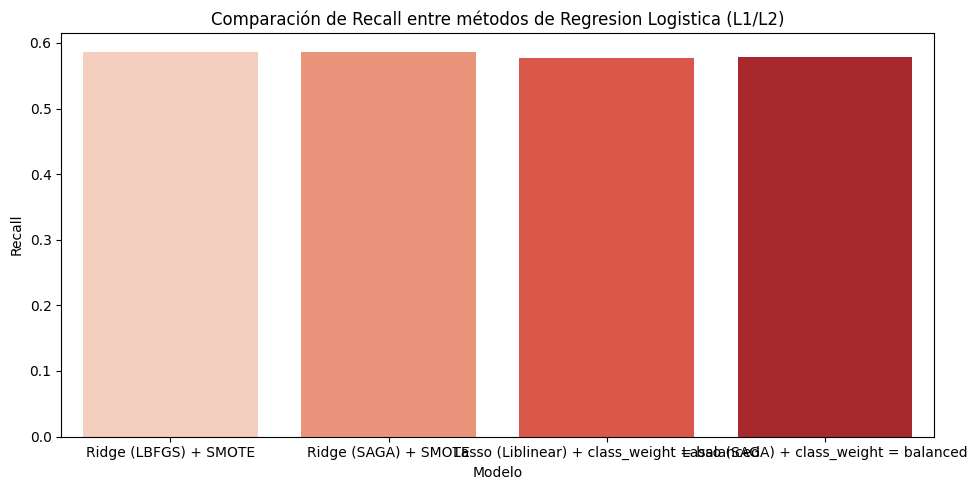

In [158]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="Recall", data=resultados, palette="Reds")
plt.title("Comparación de Recall entre métodos de Regresion Logistica (L1/L2)")
plt.tight_layout()
plt.show()

C:\Users\taran\AppData\Local\Temp\ipykernel_21620\163497550.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Tiempo (s)", data=resultados, palette="Reds")


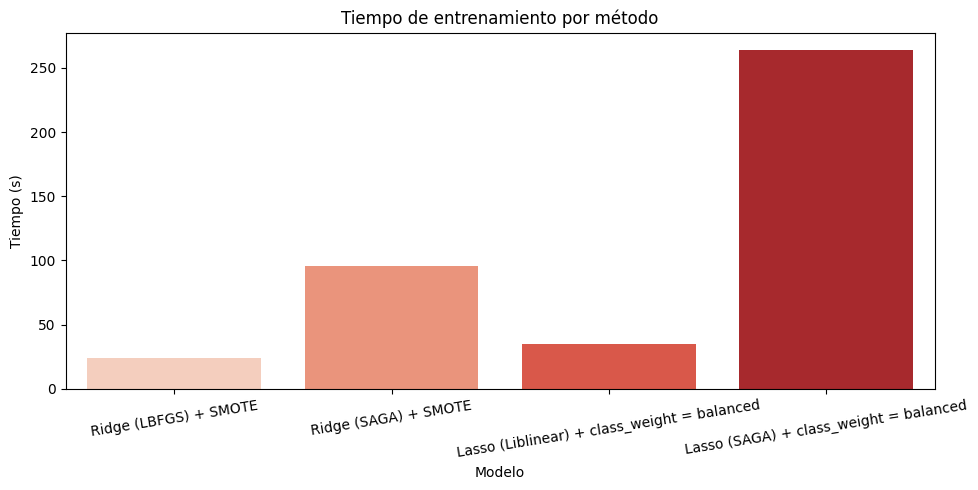

In [159]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="Tiempo (s)", data=resultados, palette="Reds")
plt.title("Tiempo de entrenamiento por método")
plt.xticks(rotation=9)
plt.tight_layout()
plt.show()

## **5.4 Técnicas de optimización para XGBoost**

In [160]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [161]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [163]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [164]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [165]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n{nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


### **5.4.1 XGBoost estándar**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


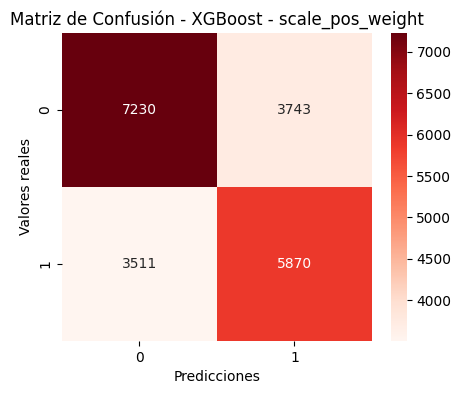


XGBoost - scale_pos_weight
Accuracy: 0.644 | Precision: 0.611 | Recall: 0.626 | F1: 0.618
AUC: 0.697
              precision    recall  f1-score   support

           0       0.67      0.66      0.67     10973
           1       0.61      0.63      0.62      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.64      0.64      0.64     20354



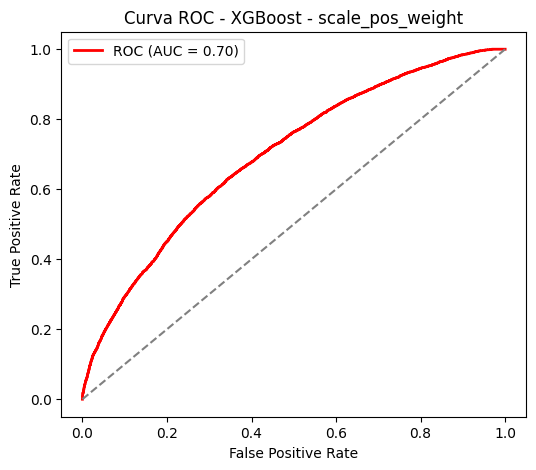

In [166]:
resultados_xgb = []


ratio = (y_train == 0).sum() / (y_train == 1).sum()


start = time.time()

xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="exact",
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        scale_pos_weight=ratio,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_pipeline.fit(X_train, y_train)

end = time.time()


metrics_xgb = evaluar_modelo(xgb_pipeline, X_test, y_test, "XGBoost - scale_pos_weight")
metrics_xgb["Tiempo (s)"] = round(end - start, 3)
resultados_xgb.append(metrics_xgb)


### **5.4.2 XGBoost usando tree_method=’hist’**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


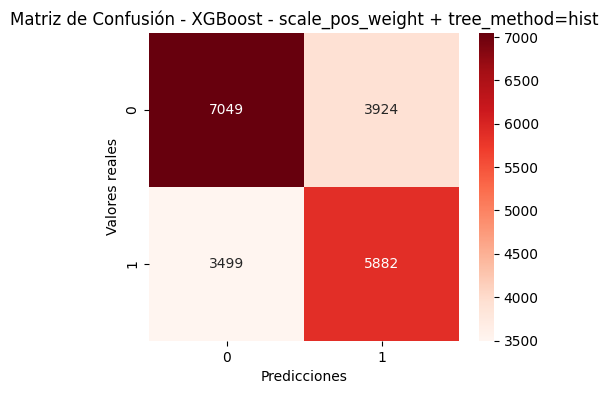


XGBoost - scale_pos_weight + tree_method=hist
Accuracy: 0.635 | Precision: 0.600 | Recall: 0.627 | F1: 0.613
AUC: 0.687
              precision    recall  f1-score   support

           0       0.67      0.64      0.66     10973
           1       0.60      0.63      0.61      9381

    accuracy                           0.64     20354
   macro avg       0.63      0.63      0.63     20354
weighted avg       0.64      0.64      0.64     20354



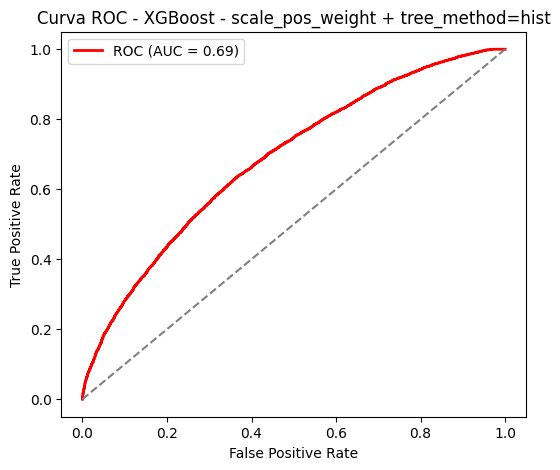

In [167]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()


start = time.time()
xgb_hist = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        tree_method="hist",
        use_label_encoder=False,
        random_state=42,
        n_estimators=200,
        scale_pos_weight=ratio   
    ))
])

xgb_hist.fit(X_train, y_train)
end = time.time()

# Evaluar el modelo
metrics_hist = evaluar_modelo(xgb_hist, X_test, y_test, "XGBoost - scale_pos_weight + tree_method=hist")
metrics_hist["Tiempo (s)"] = round(end - start, 3)
resultados_xgb.append(metrics_hist)

### **5.4.3 XGBoost usando tree_method=’gpu_hist’**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [13:29:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0

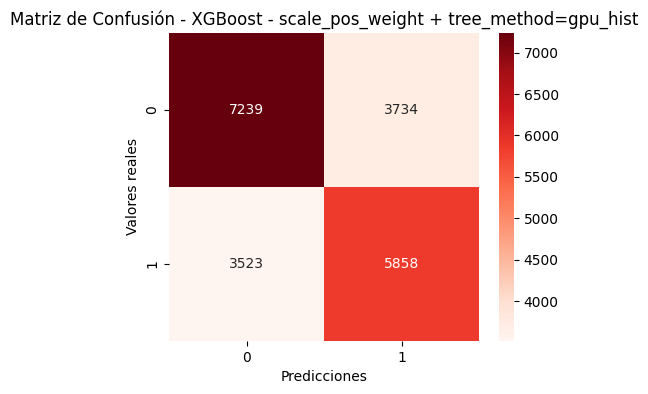


XGBoost - scale_pos_weight + tree_method=gpu_hist
Accuracy: 0.643 | Precision: 0.611 | Recall: 0.624 | F1: 0.618
AUC: 0.697
              precision    recall  f1-score   support

           0       0.67      0.66      0.67     10973
           1       0.61      0.62      0.62      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.64      0.64      0.64     20354



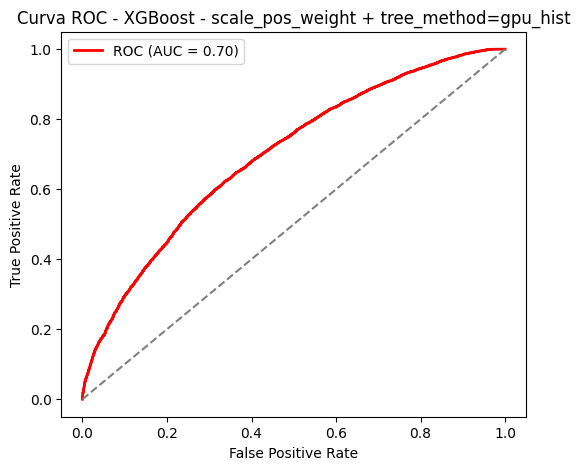

In [168]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()


try:
    start = time.time()
    xgb_gpu_balanced = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="gpu_hist",  # Usa GPU
            use_label_encoder=False,
            random_state=42,
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            scale_pos_weight=ratio,  # Balanceo automático
            n_jobs=-1
        ))
    ])
    xgb_gpu_balanced.fit(X_train, y_train)
    end = time.time()

    metrics_gpu_bal = evaluar_modelo(xgb_gpu_balanced, X_test, y_test, "XGBoost - scale_pos_weight + tree_method=gpu_hist")
    metrics_gpu_bal["Tiempo (s)"] = round(end - start, 3)
    resultados_xgb.append(metrics_gpu_bal)

except Exception as e:
    print("⚠️ GPU no disponible o error en XGBoost GPU:", e)


### **5.4.4 XGBoost usando tree_method=’hist’ y Regularizacion (L1/L2)**

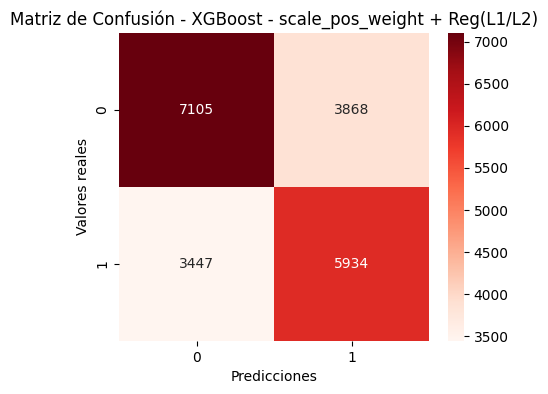


XGBoost - scale_pos_weight + Reg(L1/L2)
Accuracy: 0.641 | Precision: 0.605 | Recall: 0.633 | F1: 0.619
AUC: 0.695
              precision    recall  f1-score   support

           0       0.67      0.65      0.66     10973
           1       0.61      0.63      0.62      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.64      0.64      0.64     20354



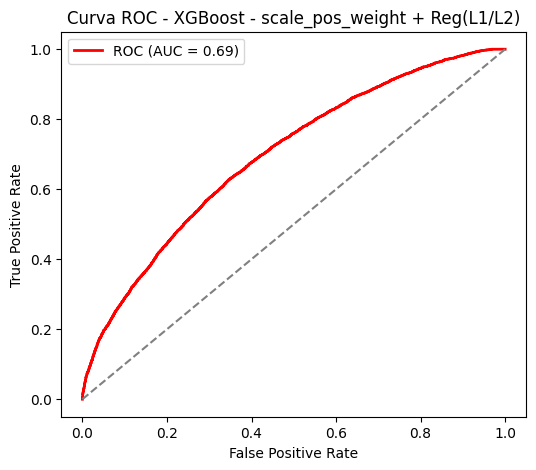

In [169]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()


start = time.time()

xgb_reg_bal = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",       # Método rápido basado en histogramas (CPU)
    reg_lambda=5.0,           # Regularización L2
    reg_alpha=2.0,            # Regularización L1
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=ratio,   # Balanceo automático
    random_state=42,
    n_jobs=-1
)
xgb_reg_bal.fit(preprocessor.fit_transform(X_train), y_train)

end = time.time()


metrics_reg_bal = evaluar_modelo(
    xgb_reg_bal,
    preprocessor.transform(X_test),
    y_test,
    "XGBoost - scale_pos_weight + Reg(L1/L2)"
)
metrics_reg_bal["Tiempo (s)"] = round(end - start, 3)
resultados_xgb.append(metrics_reg_bal)

### **5.4.5 Resultados para XGBoost y sus metodos de optimizacion**

In [170]:
df_resultados_xgb = pd.DataFrame(resultados_xgb)

columnas = ["Modelo", "Accuracy", "Precision", "Recall", "F1", "AUC", "Tiempo (s)"]
df_resultados_xgb = df_resultados_xgb[[col for col in columnas if col in df_resultados_xgb.columns]]

display(df_resultados_xgb.sort_values(by="Recall", ascending=False))


,Modelo,Accuracy,Precision,Recall,F1,AUC,Tiempo (s)
3,XGBoost - scale_pos_weight + Reg(L1/L2),0.640611,0.605387,0.632555,0.618673,0.694835,2.100
1,XGBoost - scale_pos_weight + tree_method=hist,0.635305,0.599837,0.627012,0.613123,0.686689,1.285
0,XGBoost - scale_pos_weight,0.643608,0.610631,0.625733,0.618090,0.697293,7.312
2,XGBoost - scale_pos_weight + tree_method=gpu_hist,0.643461,0.610717,0.624454,0.617509,0.697477,1.771


C:\Users\taran\AppData\Local\Temp\ipykernel_21620\1306540652.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="Recall", data=df_resultados_xgb, palette="Reds")


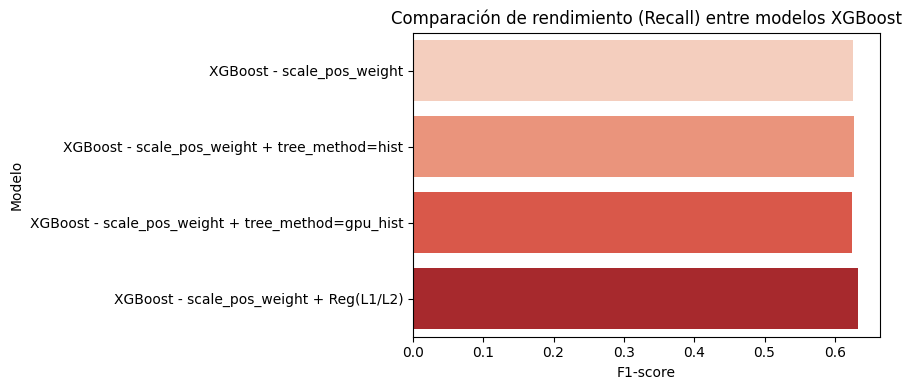

In [186]:
plt.figure(figsize=(9, 4))
sns.barplot(y="Modelo", x="Recall", data=df_resultados_xgb, palette="Reds")
plt.title("Comparación de rendimiento (Recall) entre modelos XGBoost")
plt.xlabel("F1-score")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()

C:\Users\taran\AppData\Local\Temp\ipykernel_21620\2125335975.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="Tiempo (s)", data=df_resultados_xgb, palette="Reds")


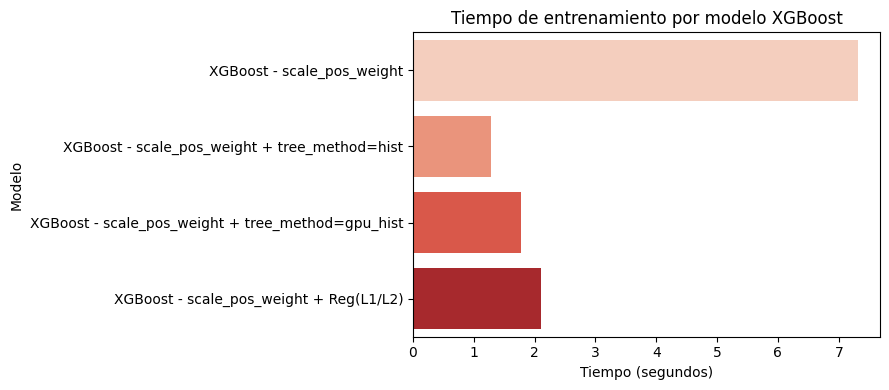

In [187]:
plt.figure(figsize=(9, 4))
sns.barplot(y="Modelo", x="Tiempo (s)", data=df_resultados_xgb, palette="Reds")
plt.title("Tiempo de entrenamiento por modelo XGBoost")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()

## **5.5 Técnicas de optimización para SVM**

In [173]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [174]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [176]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [177]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [178]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    """Evalúa un modelo y grafica sus métricas principales"""
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n🔹 {nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

### **5.5.1 SVM estándar**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearnex\svm\_common.py:249: RuntimeWarning: random_state does not influence oneDAL SVM results
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


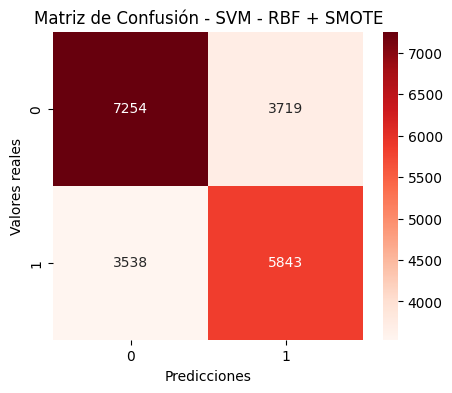


🔹 SVM - RBF + SMOTE
Accuracy: 0.643 | Precision: 0.611 | Recall: 0.623 | F1: 0.617
AUC: 0.693
              precision    recall  f1-score   support

           0       0.67      0.66      0.67     10973
           1       0.61      0.62      0.62      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.64      0.64      0.64     20354



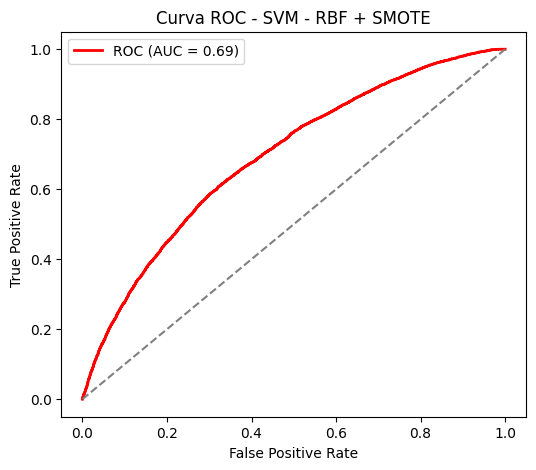

In [179]:
resultados_svm = []

start = time.time()
svm_pipeline_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        random_state=42
    ))
])
svm_pipeline_smote.fit(X_train, y_train)
end = time.time()

metrics_svm_smote = evaluar_modelo(svm_pipeline_smote, X_test, y_test, "SVM - RBF + SMOTE")
metrics_svm_smote["Tiempo (s)"] = round(end - start, 3)
resultados_svm.append(metrics_svm_smote)

### **5.5.2 SVM usando LinearSVC**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


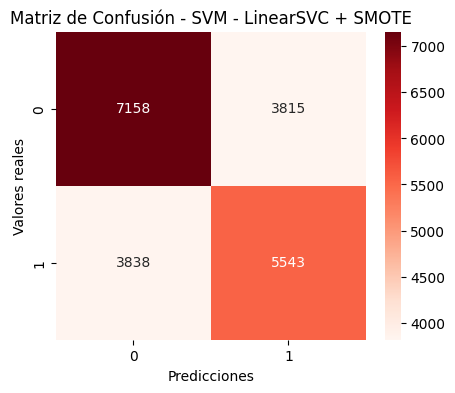


🔹 SVM - LinearSVC + SMOTE
Accuracy: 0.624 | Precision: 0.592 | Recall: 0.591 | F1: 0.592
              precision    recall  f1-score   support

           0       0.65      0.65      0.65     10973
           1       0.59      0.59      0.59      9381

    accuracy                           0.62     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.62      0.62      0.62     20354



In [180]:
start = time.time()
svm_linear_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LinearSVC(C=1.0, max_iter=2000, dual=False, random_state=42))
])
svm_linear_smote.fit(X_train, y_train)
end = time.time()

metrics_linear_smote = evaluar_modelo(svm_linear_smote, X_test, y_test, "SVM - LinearSVC + SMOTE")
metrics_linear_smote["Tiempo (s)"] = round(end - start, 3)
resultados_svm.append(metrics_linear_smote)

### **5.5.3 SVM usando SGDClassifier**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


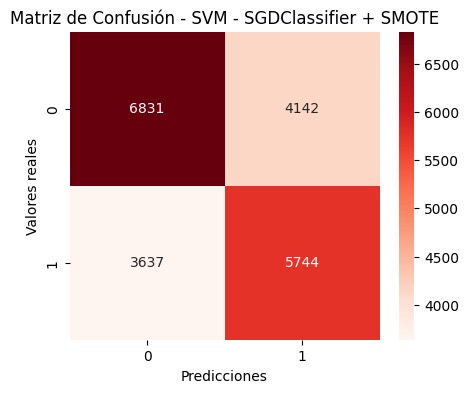


🔹 SVM - SGDClassifier + SMOTE
Accuracy: 0.618 | Precision: 0.581 | Recall: 0.612 | F1: 0.596
              precision    recall  f1-score   support

           0       0.65      0.62      0.64     10973
           1       0.58      0.61      0.60      9381

    accuracy                           0.62     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.62      0.62      0.62     20354



In [181]:
start = time.time()
svm_sgd_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", SGDClassifier(
        loss="hinge",
        alpha=0.0001,
        max_iter=1000,
        random_state=42
    ))
])
svm_sgd_smote.fit(X_train, y_train)
end = time.time()

metrics_sgd_smote = evaluar_modelo(svm_sgd_smote, X_test, y_test, "SVM - SGDClassifier + SMOTE")
metrics_sgd_smote["Tiempo (s)"] = round(end - start, 3)
resultados_svm.append(metrics_sgd_smote)

### **5.5.4 SVM usando RBF con RFF**

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


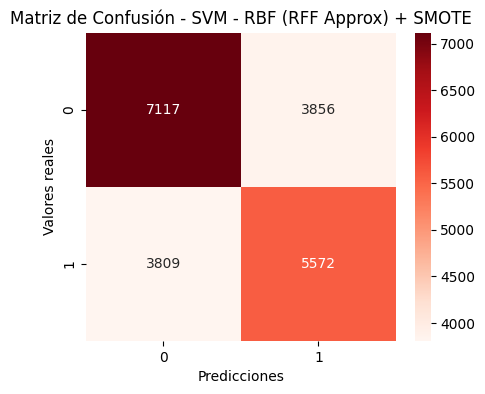


🔹 SVM - RBF (RFF Approx) + SMOTE
Accuracy: 0.623 | Precision: 0.591 | Recall: 0.594 | F1: 0.592
              precision    recall  f1-score   support

           0       0.65      0.65      0.65     10973
           1       0.59      0.59      0.59      9381

    accuracy                           0.62     20354
   macro avg       0.62      0.62      0.62     20354
weighted avg       0.62      0.62      0.62     20354



In [182]:
start = time.time()
svm_rff_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("rff", RBFSampler(gamma=0.1, n_components=500, random_state=42)),
    ("classifier", LinearSVC(C=1.0, max_iter=2000, dual=False, random_state=42))
])
svm_rff_smote.fit(X_train, y_train)
end = time.time()

metrics_rff_smote = evaluar_modelo(svm_rff_smote, X_test, y_test, "SVM - RBF (RFF Approx) + SMOTE")
metrics_rff_smote["Tiempo (s)"] = round(end - start, 3)
resultados_svm.append(metrics_rff_smote)

### **5.5.5 Resultados para SVM y sus metodos de optimizacion**

In [183]:

tabla_resultados = pd.DataFrame(resultados_svm)
print("\n Resultados comparativos - SVM optimizadas:\n")

display(tabla_resultados.sort_values(by="Recall", ascending=False))



 Resultados comparativos - SVM optimizadas:



,Modelo,Accuracy,Precision,Recall,F1,AUC,Tiempo (s)
0,SVM - RBF + SMOTE,0.643461,0.611065,0.622855,0.616903,0.69294,109.360
2,SVM - SGDClassifier + SMOTE,0.617815,0.581024,0.612301,0.596253,NaN,3.694
3,SVM - RBF (RFF Approx) + SMOTE,0.623416,0.591006,0.593967,0.592482,NaN,15.640
1,SVM - LinearSVC + SMOTE,0.624005,0.592327,0.590875,0.591600,NaN,14.944


C:\Users\taran\AppData\Local\Temp\ipykernel_21620\1090512382.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="Recall", data=tabla_resultados, palette="Reds")


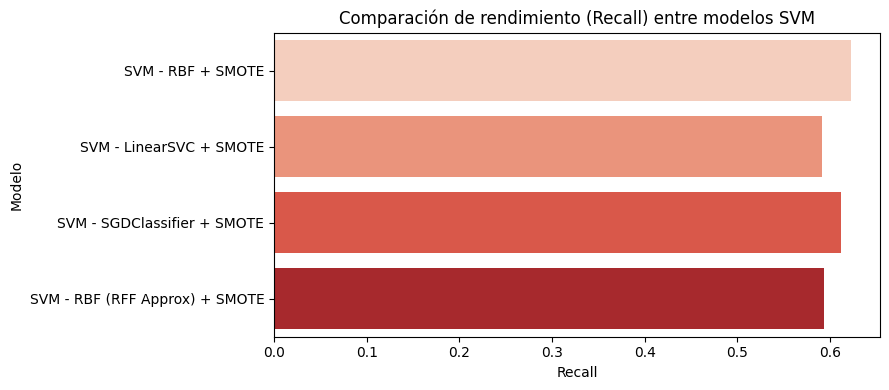

In [184]:
plt.figure(figsize=(9, 4))
sns.barplot(y="Modelo", x="Recall", data=tabla_resultados, palette="Reds")
plt.title("Comparación de rendimiento (Recall) entre modelos SVM")
plt.xlabel("Recall")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()

C:\Users\taran\AppData\Local\Temp\ipykernel_21620\2695625736.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="Tiempo (s)", data=tabla_resultados, palette="Reds")


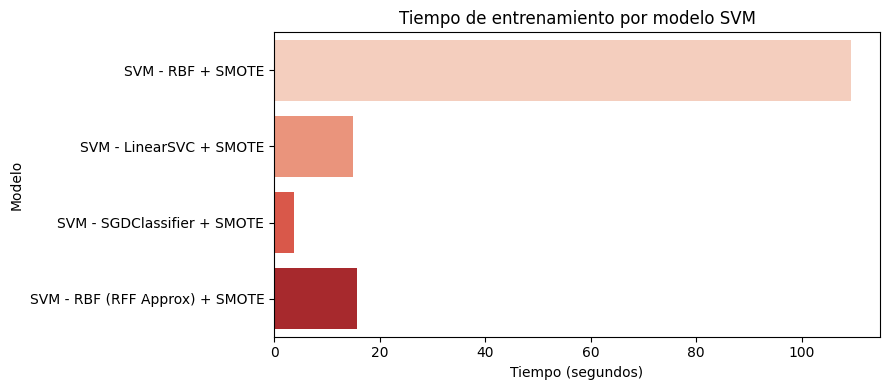

In [185]:
plt.figure(figsize=(9, 4))
sns.barplot(y="Modelo", x="Tiempo (s)", data=tabla_resultados, palette="Reds")
plt.title("Tiempo de entrenamiento por modelo SVM")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()

## **5.6 Comparacion de mejores modelos seleccionados usando tecnicas de optimizacion**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


resultados = [
    metrics_kd_smote,
    metrics_knnstd_smote,
    metrics_ball_smote,
    metrics_faiss,
    metrics_lasso_std,
    metrics_ridge_std,
    metrics_lasso_saga,
    metrics_ridge_saga,
    metrics_xgb,
    metrics_hist,
    metrics_gpu_bal,
    metrics_reg_bal,
    metrics_svm_smote,
    metrics_linear_smote,
    metrics_sgd_smote,
    metrics_rff_smote
]


In [200]:
df_resultados = pd.DataFrame(resultados).sort_values(by="Recall", ascending=False)
display(df_resultados)

# Paleta Reds
palette = sns.color_palette("Reds", 20)

,Modelo,Accuracy,Precision,Recall,F1,AUC,Tiempo (s)
11,XGBoost - scale_pos_weight + Reg(L1/L2),0.640611,0.605387,0.632555,0.618673,0.694835,2.100
9,XGBoost - scale_pos_weight + tree_method=hist,0.635305,0.599837,0.627012,0.613123,0.686689,1.285
8,XGBoost - scale_pos_weight,0.643608,0.610631,0.625733,0.618090,0.697293,7.312
10,XGBoost - scale_pos_weight + tree_method=gpu_hist,0.643461,0.610717,0.624454,0.617509,0.697477,1.771
12,SVM - RBF + SMOTE,0.643461,0.611065,0.622855,0.616903,0.692940,109.360
14,SVM - SGDClassifier + SMOTE,0.617815,0.581024,0.612301,0.596253,NaN,3.694
15,SVM - RBF (RFF Approx) + SMOTE,0.623416,0.591006,0.593967,0.592482,NaN,15.640
13,SVM - LinearSVC + SMOTE,0.624005,0.592327,0.590875,0.591600,NaN,14.944
5,Ridge (LBFGS) + SMOTE,0.626265,0.596162,0.586185,0.591131,0.680056,23.866
7,Ridge (SAGA) + SMOTE,0.626363,0.596291,0.586185,0.591195,0.680046,95.629


C:\Users\taran\AppData\Local\Temp\ipykernel_21620\1175788266.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="Recall", data=top10_f1, palette="Reds_r")


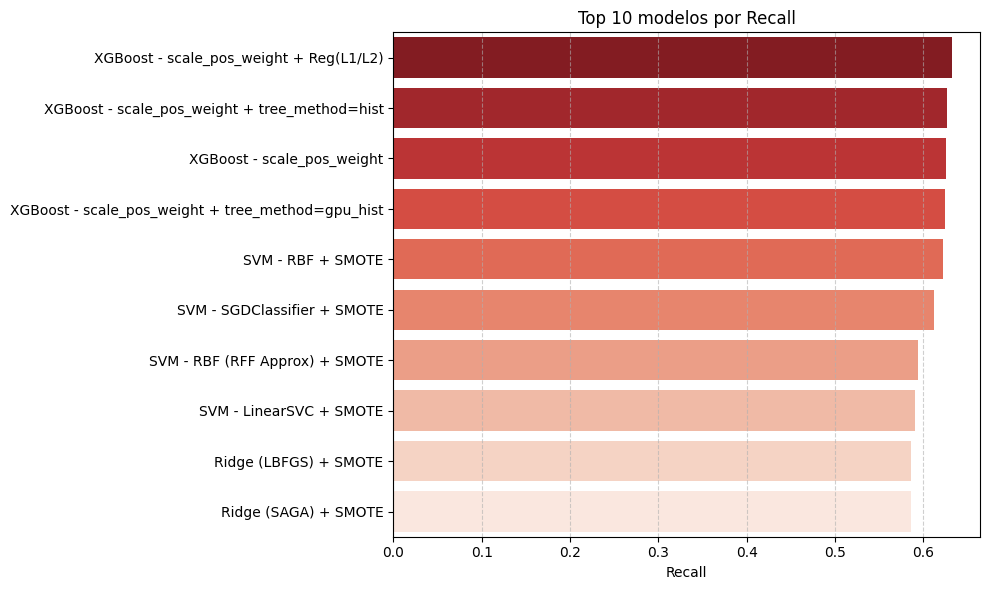

In [195]:
top10_f1 = df_resultados.sort_values(by="Recall", ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(y="Modelo", x="Recall", data=top10_f1, palette="Reds_r")
plt.xlabel("Recall")
plt.ylabel("")
plt.title("Top 10 modelos por Recall")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\taran\AppData\Local\Temp\ipykernel_21620\1902294764.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="Tiempo (s)", data=top10_tiempo, palette="Reds_r")


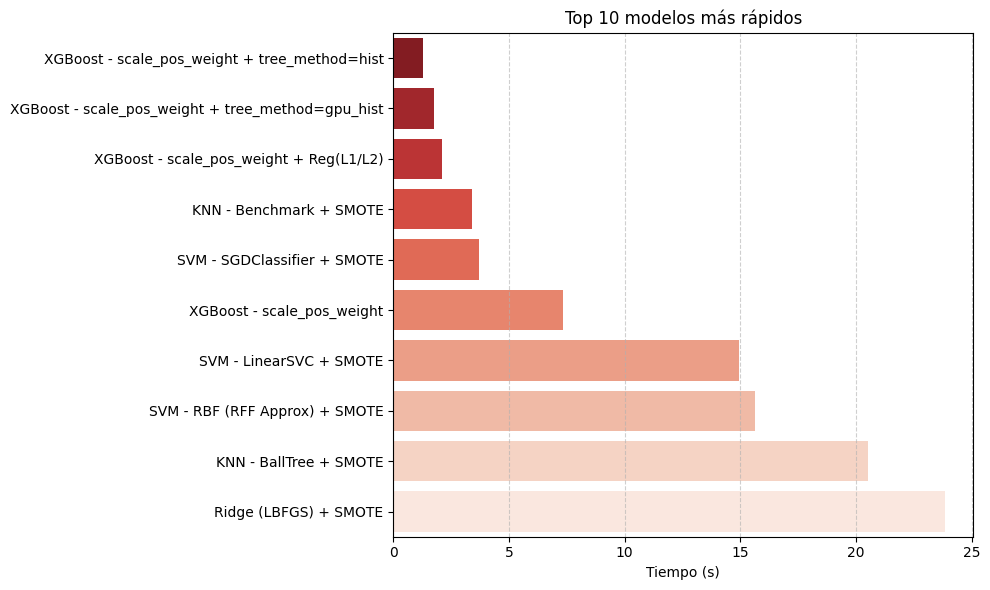

In [196]:
top10_tiempo = df_resultados.sort_values(by="Tiempo (s)").head(10)
plt.figure(figsize=(10,6))
sns.barplot(y="Modelo", x="Tiempo (s)", data=top10_tiempo, palette="Reds_r")
plt.xlabel("Tiempo (s)")
plt.ylabel("")
plt.title("Top 10 modelos más rápidos")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

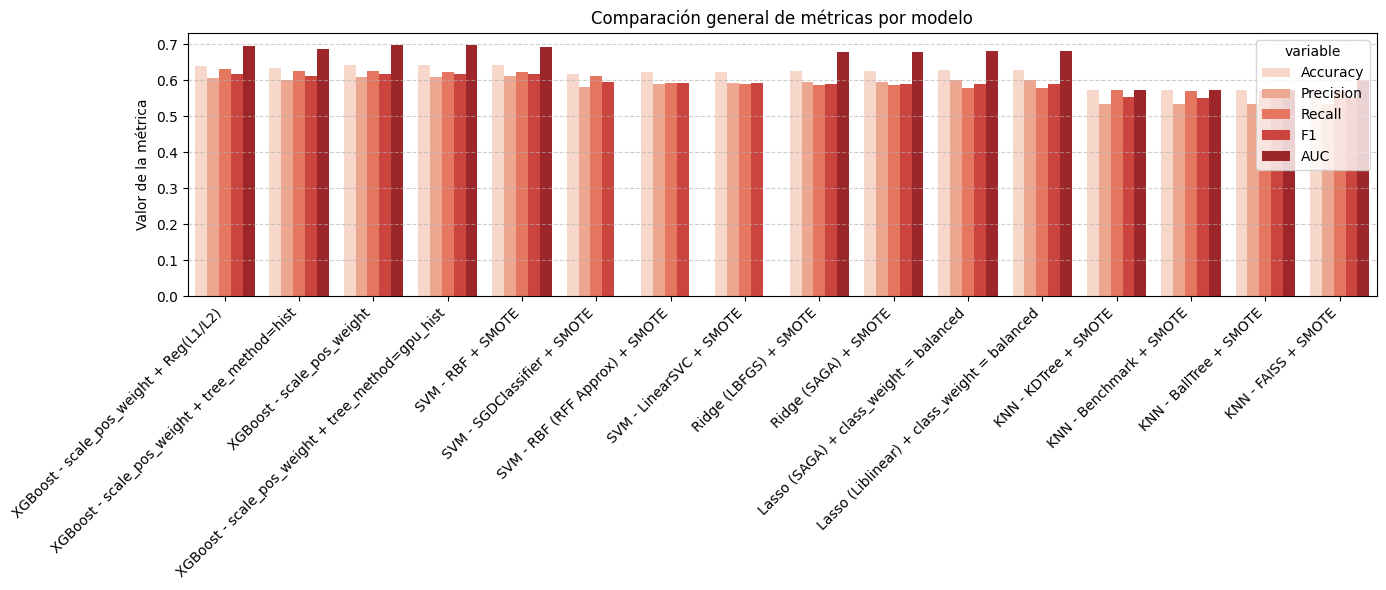

In [198]:
metricas = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
plt.figure(figsize=(14,6))
sns.barplot(
    data=df_resultados.melt(id_vars="Modelo", value_vars=metricas),
    x="Modelo", y="value", hue="variable", palette="Reds"
)
plt.title("Comparación general de métricas por modelo")
plt.ylabel("Valor de la métrica")
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()